
image 1/1 /home/mdsme/Documents/project/Gilang/cariesDetection/dataset/Caries/2ac917cc-Ranjbar_Azam_2022-05-14123922_jpg.rf.e27baf65daa54d9765a6e216e59de398.jpg: 640x640 1 Deep Caries, 14.4ms
Speed: 2.3ms preprocess, 14.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


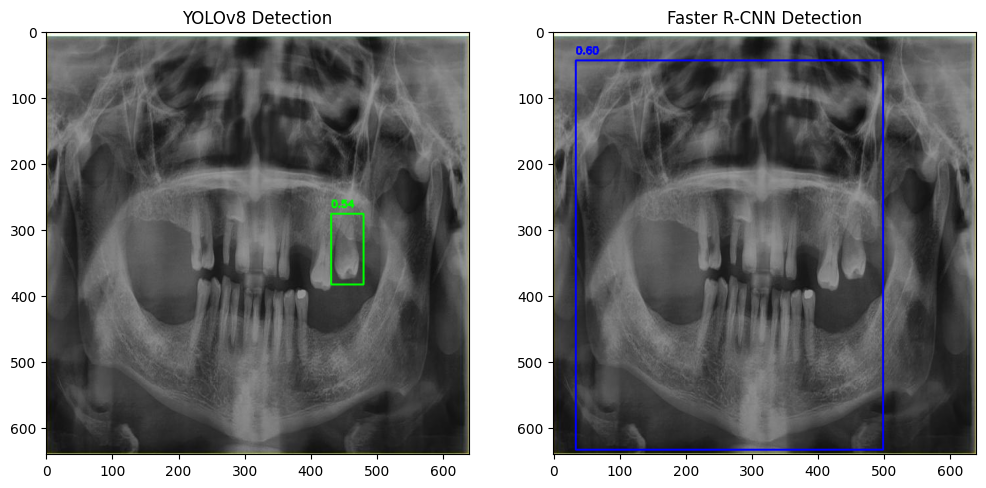

Average YOLOv8 Accuracy: 0.54
Average Faster R-CNN Accuracy: 0.60


In [3]:
import torch
import cv2
import numpy as np
import torchvision.transforms as transforms
import torchvision.models.detection as detection
from ultralytics import YOLO
from PIL import Image
import matplotlib.pyplot as plt

# Load YOLOv8 model
yolo_model = YOLO('best.pt')

def detect_yolo(image_path):
    results = yolo_model(image_path)
    img = cv2.imread(image_path)
    for result in results:
        for box, score in zip(result.boxes.xyxy, result.boxes.conf):
            x1, y1, x2, y2 = map(int, box.tolist())
            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(img, f"{score:.2f}", (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    return img, [score.item() for score in result.boxes.conf]

# Load Faster R-CNN model
faster_rcnn = detection.fasterrcnn_resnet50_fpn(pretrained=True)
faster_rcnn.eval()

def detect_faster_rcnn(image_path):
    img = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([transforms.ToTensor()])
    img_tensor = transform(img).unsqueeze(0)
    
    with torch.no_grad():
        predictions = faster_rcnn(img_tensor)
    
    img = cv2.imread(image_path)
    scores = []
    for box, score in zip(predictions[0]['boxes'], predictions[0]['scores']):
        if score > 0.5:
            x1, y1, x2, y2 = map(int, box.tolist())
            cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
            cv2.putText(img, f"{score:.2f}", (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
            scores.append(score.item())
    return img, scores

# Load image and perform detections
image_path = '/home/mdsme/Documents/project/Gilang/cariesDetection/dataset/Caries/2ac917cc-Ranjbar_Azam_2022-05-14123922_jpg.rf.e27baf65daa54d9765a6e216e59de398.jpg'
yolo_result, yolo_scores = detect_yolo(image_path)
faster_rcnn_result, faster_rcnn_scores = detect_faster_rcnn(image_path)

# Display results
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(cv2.cvtColor(yolo_result, cv2.COLOR_BGR2RGB))
axs[0].set_title("YOLOv8 Detection")
axs[1].imshow(cv2.cvtColor(faster_rcnn_result, cv2.COLOR_BGR2RGB))
axs[1].set_title("Faster R-CNN Detection")
plt.show()

# Compute average accuracy
avg_yolo_accuracy = sum(yolo_scores) / len(yolo_scores) if yolo_scores else 0
avg_faster_rcnn_accuracy = sum(faster_rcnn_scores) / len(faster_rcnn_scores) if faster_rcnn_scores else 0

print(f"Average YOLOv8 Accuracy: {avg_yolo_accuracy:.2f}")
print(f"Average Faster R-CNN Accuracy: {avg_faster_rcnn_accuracy:.2f}")